# imports

In [11]:
# ===============================
# 系統 / 檔案 / 路徑操作
# ===============================
import os
import sys
from pathlib import Path
import glob
import io
import zipfile
import json
import base64
import random

# 自訂 module 路徑
sys.path.append("C:/Users/GAI/Desktop/Scott/NCA_Research")

# ===============================
# 圖像 / 視覺化
# ===============================
import PIL.Image
import PIL.ImageDraw
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import matplotlib.cm as cm

from IPython.display import Image, HTML, Markdown, clear_output, display

# ===============================
# 數值計算 / 資料處理
# ===============================
import numpy as np
import pandas as pd
import h5py

# ===============================
# PyTorch / 深度學習
# ===============================
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import torchvision.models as models

# ===============================
# 機器學習 / 其他工具
# ===============================
from sklearn.decomposition import PCA
import piq
from tqdm import trange, tqdm_notebook, tnrange

# ===============================
# 自訂工具 / 專案內模組
# ===============================
from core_utils.plotting import *
from core_utils.utils_image import *
from core_utils.viz_train import *
from E4_PI_NCA.utils.helper import *
from E4_PI_NCA.utils.Dataset import *
from E4_PI_NCA.utils.PI_Metric import ScaledPhysicsMetrics

# ===============================
# 設定 / GPU
# ===============================
torch.set_default_device('cuda')

# ===============================
# Notebook 特殊指令
# ===============================
!nvidia-smi -L


GPU 0: NVIDIA GeForce RTX 3080 Laptop GPU (UUID: GPU-6cf8054c-6c04-c256-2ebb-8137cfc2e798)


# helper

In [12]:
def normalize_to_01(x):
    x_min, x_max = x.amin(dim=(1,2,3), keepdim=True), x.amax(dim=(1,2,3), keepdim=True)
    return (x - x_min) / (x_max - x_min + 1e-8)

def sperate_base_channels(x, base_channel_count=6):
    """將基礎通道與其他通道分離"""
    base_channels = x[:, :base_channel_count, :, :]
    other_channels = x[:, base_channel_count:, :, :]
    return base_channels, other_channels

In [13]:
def convert_CHW_to_rgb(tensor_CHW: torch.Tensor, mode="pca", cmap="Spectral"):
    """
    Convert CHW tensor to HWC RGB numpy array for visualization.

    Args:
        tensor_CHW: torch.Tensor, shape (C,H,W)
        mode: "single" -> use first 1~3 channels,
              "pca" -> apply PCA to reduce channels to 3
        cmap: matplotlib colormap name, used when mode="single" and C=1
    Returns:
        data_rgb: np.array, shape (H,W,3), values in [0,1]
    """
    assert tensor_CHW.ndim == 3, "Input must be (C,H,W)"
    C, H, W = tensor_CHW.shape
    data_np = tensor_CHW.cpu().numpy()
    
    if mode == "single":
        if C == 1:
            # 單 channel，用 colormap
            norm_data = (data_np[0] - data_np[0].min()) / (data_np[0].ptp() + 1e-8)
            cmap_func = cm.get_cmap(cmap)
            data_rgb = cmap_func(norm_data)[..., :3]  # drop alpha
        else:
            # 取前 3 channel
            if C >=3:
                data_rgb = data_np[:3]
            else:
                # 補足 channel
                pad = np.zeros((3-C, H, W))
                data_rgb = np.concatenate([data_np, pad], axis=0)
            # normalize to 0-1
            data_rgb = (data_rgb - data_rgb.min()) / (data_rgb.max()-data_rgb.min()+1e-8)
            data_rgb = np.transpose(data_rgb, (1,2,0))  # HWC
    elif mode == "pca":
        # flatten H*W x C
        flat_data = data_np.reshape(C, -1).T  # shape (H*W, C)
        pca = PCA(n_components=3)
        flat_rgb = pca.fit_transform(flat_data)
        # clip 到指定範圍，不做整體 normalize
        data_rgb = np.clip(flat_rgb, 0, 1)
    else:
        raise ValueError("mode must be 'single' or 'pca'")
    
    return data_rgb

# physics loss

In [14]:
# 索引 (Indices)
IDX_U_COMPONENTS = 6  # uped = < u >
IDX_V_COMPONENTS = 7  # vped = < v >
IDX_U_MAGNITUDE = 8  # Uped = < sqrt(u^2+v^2) >
IDX_TKE = 9  # TKEped
IDX_T_UW = 10  # Tuwped


class PhysicsLoss(nn.Module):
    """
    計算基於物理屬性的可微分損失 (PINN Loss)。

    V3 - L_u_bound:
    - 正確地將速度一致性作為單向不等式約束：
      <sqrt(u^2+v^2)> (U_pred) >= sqrt(<u>^2 + <v>^2) (reconstructed_mean_mag)
    - 懲罰 L_u_bound = relu(reconstructed_mean_mag - U_pred)
    """

    def __init__(self, alpha: float = 2.25, weights: dict = None):
        super().__init__()
        self.alpha = alpha

        if weights is None:
            self.weights = {
                "L_k_neg": 1.0,  # TKE 負值懲罰
                "L_flux": 1.0,  # 通量超界懲罰
                "L_u_bound": 1.0,  # 速度邊界不等式懲罰
            }
        else:
            self.weights = weights

        print("PhysicsLoss initialized (V3 - Physical Inequality)")
        print(f"Loss Weights: {self.weights}")

    def forward(self, pred: torch.Tensor) -> tuple[torch.Tensor, dict]:
        """
        計算總的物理損失。
        :param pred: 模型的預測輸出 (B, C, H, W)
        :return: (total_loss, loss_dict)
        """

        # --- 1. 提取所需通道 ---
        u_pred = pred[:, IDX_U_COMPONENTS]  # < u >
        v_pred = pred[:, IDX_V_COMPONENTS]  # < v >
        U_pred = pred[:, IDX_U_MAGNITUDE]  # < sqrt(u^2+v^2) >
        TKE_pred = pred[:, IDX_TKE]
        T_uw_pred = pred[:, IDX_T_UW]

        loss_dict = {}
        total_loss = torch.tensor(0.0, device=pred.device)

        # --- 2. L_k_neg (TKE 負值懲罰) ---
        L_k_neg = torch.mean(torch.relu(-TKE_pred))
        loss_dict["L_k_neg"] = L_k_neg
        total_loss += self.weights["L_k_neg"] * L_k_neg

        # --- 3. L_flux (通量超界懲罰) ---
        TKE_non_neg = torch.relu(TKE_pred)
        flux_bound_error = torch.abs(T_uw_pred) - (self.alpha * TKE_non_neg)
        L_flux = torch.mean(torch.relu(flux_bound_error))
        loss_dict["L_flux"] = L_flux
        total_loss += self.weights["L_flux"] * L_flux

        # --- 4. L_u_bound (速度邊界不等式) ---
        # 計算平均速度的速率: sqrt(<u>^2 + <v>^2)
        reconstructed_mean_mag = torch.sqrt(u_pred**2 + v_pred**2 + 1e-8)

        # 物理定律是: U_pred >= reconstructed_mean_mag
        # 違規 (Violation) 是當: reconstructed_mean_mag > U_pred
        violation = reconstructed_mean_mag - U_pred

        # 僅懲罰違規的部分 (單向約束)
        L_u_bound = torch.mean(torch.relu(violation))
        loss_dict["L_u_bound"] = L_u_bound
        total_loss += self.weights["L_u_bound"] * L_u_bound

        loss_dict["L_physics_total"] = total_loss
        return total_loss, loss_dict

# NCA model

In [15]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
IDX_GEO_MASK = 2
def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = F.pad(y, [1, 1, 1, 1], 'circular')
  y = F.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96):
    super().__init__()
    self.chn = chn
    self.w1 = nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data.zero_()

  def forward(self, x, update_rate=0.5):
    y = perception(x)
    y = self.w2(torch.relu(self.w1(y)))
    b, c, h, w = y.shape
    udpate_mask = x[:,IDX_GEO_MASK:IDX_GEO_MASK+1]
    no_change = x[:, :6, :, :]
    updated = x + y * x[:, 2:3, :, :]
    return torch.cat([no_change, updated[:, 6:, :, :]], dim=1)

  def seed(self, n, sz=128):
    return torch.zeros(n, self.chn, sz, sz)

def to_rgb(x):
  return x[...,:3,:,:]+0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 5856


關於loss項我有幾個問題，請更加詳細解釋:
1.U定義一致性：
$\ell$ 建議用 Huber 或 平滑 L1：對 noise 更健壯。
\ell 本身的用意是甚麼?Huber是甚麼 為甚麼要對nosie更健壯



# clean code

In [16]:
def random_zero_blocks_multi(tensors, block_size: int = 40, n_blocks: int = 1):
    """
    Randomly set n_blocks of size block_size x block_size to zero in multiple BCHW tensors
    at the same spatial locations.

    Args:
        tensors: list of BCHW tensors [tensor1, tensor2, tensor3]
        block_size: size of the square block to zero out
        n_blocks: number of blocks to zero randomly
    Returns:
        list of tensors with blocks zeroed (in-place)
    """
    assert len(tensors) == 3, "Expect exactly 3 tensors"
    B, C, H, W = tensors[0].shape
    for t in tensors:
        assert t.shape == (B, C, H, W), "All tensors must have the same shape"

    for _ in range(n_blocks):
        top = random.randint(0, H - block_size)
        left = random.randint(0, W - block_size)
        for t in tensors:
            t[:, :, top:top+block_size, left:left+block_size] = 0
    return tensors

## func

In [17]:
# --------------------
# Config
# --------------------
DATASET_IMG_SIZE = (128, 128)
POOL_SIZE = 256
CHANNEL_C = 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --------------------
# 1. Dataset loading
# --------------------
def load_dataset(dataset_dir, channel_c=CHANNEL_C):
    loaded_dataset, dataset_city_size = load_all_cases_to_BCHW(
        dataset_dir, target_size=DATASET_IMG_SIZE, device=device
    )
    B, C, H, W = loaded_dataset.shape

    y_pool = torch.zeros((B, channel_c, H, W), device=device)
    y_pool[:, :C] = loaded_dataset

    x_pool = y_pool.clone()
    x_pool[:, 6:] = 0.0  # mask channels

    return x_pool, y_pool, dataset_city_size


# --------------------
# 2. Load models
# --------------------
def load_models(init_ckpt, pinn_ckpt):
    init_module = CA(chn=CHANNEL_C).to(device)
    pinn_module = CA(chn=CHANNEL_C).to(device)

    ckpt1 = torch.load(init_ckpt, map_location=device)
    init_module.load_state_dict(ckpt1["model_state_dict"])
    init_module.eval()

    ckpt2 = torch.load(pinn_ckpt, map_location=device)
    pinn_module.load_state_dict(ckpt2["model_state_dict"])
    pinn_module.eval()

    return init_module, pinn_module


# --------------------
# 3. Prepare batch
# --------------------
def prepare_batch(x_pool, y_pool, dataset_city_size, batch_size):
    idx = np.random.choice(len(x_pool), batch_size, replace=False)

    x_init = x_pool[idx].clone().to(device)
    x_pinn = x_pool[idx].clone().to(device)
    x_hybrid = x_pool[idx].clone().to(device)

    y_target = y_pool[idx].clone().to(device)
    batch_city_size = [dataset_city_size[i] for i in idx.tolist()]

    return x_init, x_pinn, x_hybrid, y_target, batch_city_size


# --------------------
# 4. Run rollout evaluation
# --------------------
def run_rollout(
    init_model, pinn_model, metric_fn,
    x_init, x_pinn, x_hybrid, y_target, batch_city_size,
    steps, save_every=50
):
    """
    描述：
        執行 NCA rollout 並同時紀錄模型狀態與評估指標。
        回傳每階段 metrics + 中途所有狀態張量快照。

    參數：
        init_model        ─ 初始化訓練的 NCA 模型
        pinn_model        ─ 加入物理損失之 PINN NCA 模型
        metric_fn         ─ 評估指標計算函式 (ScaledPhysicsMetrics)
        x_init            ─ 初始狀態 (Init 模型路徑)
        x_pinn            ─ 初始狀態 (PINN 模型路徑)
        x_hybrid          ─ 初始狀態 (Hybrid: 先 Init 再 PINN)
        y_target          ─ Ground truth 目標
        batch_city_size   ─ 城市尺度參數 (供物理量換算)
        steps             ─ rollout 的總步數
        save_every        ─ 每 N 步存一次狀態

    回傳：
        df_metrics  ─ pandas DataFrame (每步的指標)
        states      ─ torch.Tensor (3, T, B, C, H, W)
                      [Init Only, PINN Only, Hybrid]
                      B=Batch, T=保存的 timestep 數
    """

    # 儲存每步 metrics 的 list
    records = []

    # 暫存每次保存的狀態
    saved_states = []   # 每次 append 三個 x 狀態 (init/pinn/hybrid)

    # timestep loop
    for step in trange(steps):
        if step  == 0:
            saved_states.append(
                (
                    x_init.clone().detach().cpu(),   # 儲存到 CPU 減輕 GPU 壓力
                    x_pinn.clone().detach().cpu(),
                    x_hybrid.clone().detach().cpu(),
                )
            )

            # if step == 0:
            #     x_init,x_pinn,x_hybrid = random_zero_blocks_multi([x_init,x_pinn,x_hybrid])
                

        # ---- NCA Rollout ----
        # 這裡關閉梯度，因為我們在 inference，不進行訓練
        with torch.no_grad():

            # Init only：只用 init 模型推進
            x_init = init_model(x_init)

            # PINN only：只用 PINN 模型推進
            x_pinn = pinn_model(x_pinn)

            # Hybrid：先 init，再 PINN
            x_hybrid = init_model(x_hybrid)
            x_hybrid = pinn_model(x_hybrid)

        # ---- 保存狀態 ----
        # 每 save_every 步保存一次張量狀態
        if step % save_every == 0:
            saved_states.append(
                (
                    x_init.clone().detach().cpu(),   # 儲存到 CPU 減輕 GPU 壓力
                    x_pinn.clone().detach().cpu(),
                    x_hybrid.clone().detach().cpu(),
                )
            )

        # ---- 指標計算 ----
        m_init   = metric_fn(x_init,  y_target, batch_city_size)
        m_pinn   = metric_fn(x_pinn,  y_target, batch_city_size)
        m_hybrid = metric_fn(x_hybrid, y_target, batch_city_size)

        # 整理成 dict
        row = {"step": step}
        for k, v in m_init.items():   row[f"init_{k}"] = v.item()
        for k, v in m_pinn.items():   row[f"pinn_{k}"] = v.item()
        for k, v in m_hybrid.items(): row[f"hybrid_{k}"] = v.item()
        records.append(row)

    # ---- 轉成 DataFrame ----
    df = pd.DataFrame(records).set_index("step")

    # ---- 將 saved_states 堆成張量 ----
    # saved_states 為 list[ (init, pinn, hybrid), ... ]
    init_list, pinn_list, hybrid_list = zip(*saved_states)

    # 最終 shape = (3, T, B, C, H, W)
    states = torch.stack([
        torch.stack(init_list),      # T, B, C, H, W
        torch.stack(pinn_list),
        torch.stack(hybrid_list),
    ])

    return df, states



# --------------------
# 5. Plot
# --------------------
def plot_metrics_overtime(df_train, df_val=None):
    metric_names = [
        "data_mae_score",
        "structural_ssim_score",
        "physical_p_k_neg_score",
        "physical_p_flux_score",
        "physical_l_u_bound_score",
        "physical_continuity_score",
    ]

    color_map = {
        "init": "C0",
        "pinn": "C1",
        "hybrid": "C2"
    }

    display_name = {
        "init": "Init-NCA module",
        "pinn": "PI-NCA module",
        "hybrid": "m-NCA"
    }

    def plot_pair(ax, df, method, col, linestyle, color):
        if df is not None and col in df.columns:
            ax.plot(df.index, df[col], linestyle=linestyle, linewidth=2, color=color)

    # ===== Legend handles =====
    model_handles = [
        plt.Line2D([], [], color=c, linewidth=2)
        for c in color_map.values()
    ]
    model_labels = [display_name[m] for m in color_map]

    style_handles = [
        plt.Line2D([], [], color="black", linestyle="--", linewidth=2),
        plt.Line2D([], [], color="black", linestyle="-", linewidth=2),
    ]
    style_labels = ["Train (--)", "Val (-)"]

    # ================= Composite =================
    fig, ax = plt.subplots(figsize=(12, 6))

    for method, color in color_map.items():
        plot_pair(ax, df_train, method, f"{method}_COMPOSITE_SCORE", "--", color)
        if df_val is not None:
            plot_pair(ax, df_val, method, f"{method}_COMPOSITE_SCORE", "-", color)

    ax.set_title("Composite Score")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Score")
    ax.grid(True)

    # Composite Legends
    L1 = ax.legend(model_handles, model_labels, loc="upper left")
    ax.add_artist(L1)
    L2 = ax.legend(style_handles, style_labels, loc="lower left")

    plt.show()

    # ================= Sub Metrics =================
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True)
    axes = axes.flatten()

    for i, name in enumerate(metric_names):
        ax = axes[i]

        for method, color in color_map.items():
            plot_pair(ax, df_train, method, f"{method}_{name}", "--", color)
            if df_val is not None:
                plot_pair(ax, df_val, method, f"{method}_{name}", "-", color)

        ax.set_title(name)
        ax.set_xlabel("Steps")
        ax.set_ylabel("Score")
        ax.grid(True)

    # ===== Subplot Legends =====
    # 放在整體 figure 下方
    fig.legend(
        model_handles,
        model_labels,
        loc="lower center",
        ncol=3,
        bbox_to_anchor=(0.3, -0.04),
        frameon=False
    )

    # 第二排: linestyle legend
    fig.legend(
        style_handles,
        style_labels,
        loc="lower center",
        bbox_to_anchor=(0.1, -0.04),
        frameon=False
    )
    plt.savefig("metrics.png",dpi=300)
    plt.show()







In [18]:
def print_final_scores(df_train, df_val=None):
    metric_names = [
        "data_mae_score",
        "structural_ssim_score",
        "physical_p_k_neg_score",
        "physical_p_flux_score",
        "physical_l_u_bound_score",
        "physical_continuity_score",
    ]

    # method →顯示 label
    display_name = {
        "init": "Init-NCA_module",
        "pinn": "PI-NCA module",
        "hybrid": "m-NCA"
    }

    print("=== Composite Scores ===")
    for method in display_name.keys():
        train_col = f"{method}_COMPOSITE_SCORE"
        val_col = f"{method}_COMPOSITE_SCORE"

        final_train = df_train[train_col].iloc[-1] if train_col in df_train.columns else None
        final_val   = df_val[val_col].iloc[-1] if (df_val is not None and val_col in df_val.columns) else None

        print(f"{display_name[method]} (train): {final_train:.4f}" if final_train is not None else f"{display_name[method]} (train): N/A")
        if df_val is not None:
            print(f"{display_name[method]} (val): {final_val:.4f}" if final_val is not None else f"{display_name[method]} (val): N/A")
    print()

    print("=== Sub-metrics ===")
    for name in metric_names:
        print(f"-- {name} --")
        for method in display_name.keys():
            train_col = f"{method}_{name}"
            val_col   = f"{method}_{name}"

            final_train = df_train[train_col].iloc[-1] if train_col in df_train.columns else None
            final_val   = df_val[val_col].iloc[-1] if (df_val is not None and val_col in df_val.columns) else None

            print(f"{display_name[method]} (train): {final_train:.4f}" if final_train is not None else f"{display_name[method]} (train): N/A")
            if df_val is not None:
                print(f"{display_name[method]} (val): {final_val:.4f}" if final_val is not None else f"{display_name[method]} (val): N/A")
        print()

## main

--- Metric Baseline Calculated (Worst Score = 0) ---
MAE Max Baseline: 1.4382e-01
L_u_bound Worst Baseline: 2.9633e-01 (Perfect=5.4390e-04)
P_flux Perfect Baseline: 1.4481e-03 (Target 違規比例)
Continuity Worst Baseline: 1.0165e+00 (Perfect=1.6544e-02)


100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


--- Metric Baseline Calculated (Worst Score = 0) ---
MAE Max Baseline: 1.5799e-01
L_u_bound Worst Baseline: 3.2814e-01 (Perfect=8.2925e-04)
P_flux Perfect Baseline: 1.3137e-03 (Target 違規比例)
Continuity Worst Baseline: 1.0148e+00 (Perfect=1.4788e-02)


100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


torch.Size([3, 101, 16, 24, 128, 128])


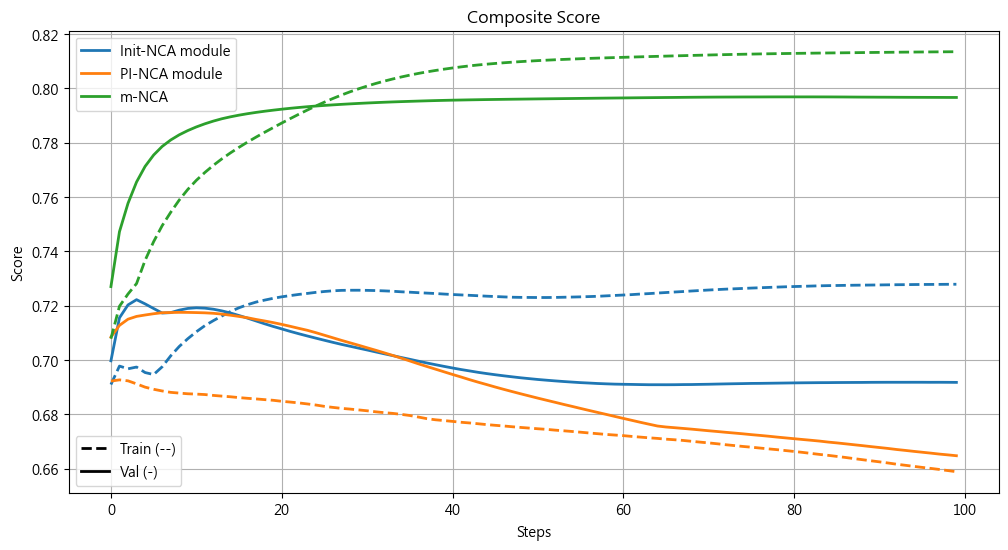

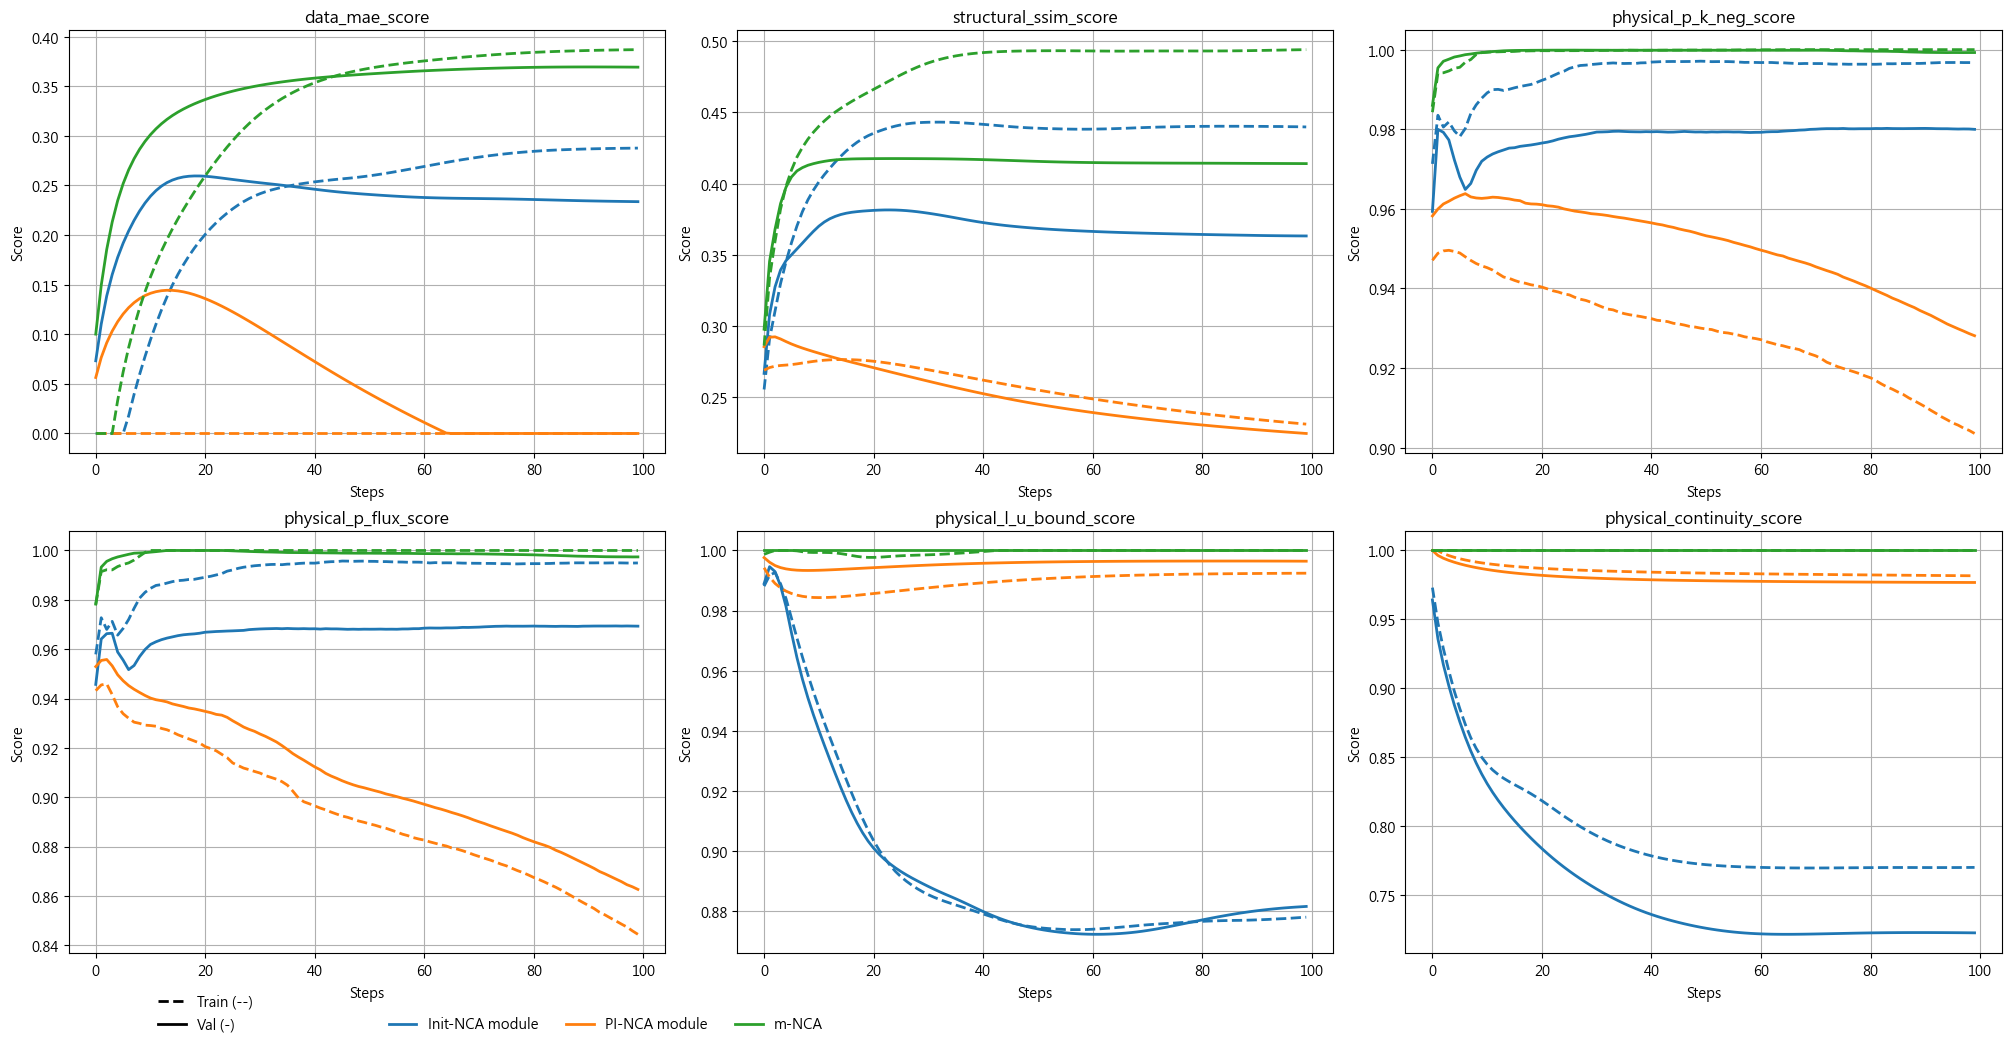

In [24]:
train_x_pool, train_y_pool, train_city_size = load_dataset("../dataset_h5/train")

init_model, pinn_model = load_models(
    '..\outputs\E4-7.1_Init-NCA_20251102-153402\ca_model_step_5000.pth',
    '..\outputs\E4-7.2_PI-NCA_20251102-162009\ca_model_step_5000.pth'
)

metric_fn = ScaledPhysicsMetrics(train_y_pool, train_city_size)

x_init, x_pinn, x_hybrid, y_target, batch_city = prepare_batch(
    train_x_pool, train_y_pool, train_city_size, batch_size=4
)

train_df, train_rollout_states = run_rollout(
    init_model, pinn_model, metric_fn,
    x_init, x_pinn, x_hybrid, y_target, batch_city,
    steps=100,
    save_every=1
)

#=========================================================
val_x_pool, val_y_pool, val_city_size = load_dataset("../dataset_h5/val")

init_model, pinn_model = load_models(
    '..\outputs\E4-7.1_Init-NCA_20251102-153402\ca_model_step_5000.pth',
    '..\outputs\E4-7.2_PI-NCA_20251102-162009\ca_model_step_5000.pth'
)

metric_fn = ScaledPhysicsMetrics(val_y_pool, val_city_size)

x_init, x_pinn, x_hybrid, y_target, batch_city = prepare_batch(
    val_x_pool, val_y_pool, val_city_size, batch_size=16
)

val_df, val_rollout_states = run_rollout(
    init_model, pinn_model, metric_fn,
    x_init, x_pinn, x_hybrid, y_target, batch_city,
    steps=100,
    save_every=1
)
print(val_rollout_states.shape)


# print_final_scores(train_df, val_df)

plot_metrics_overtime(train_df, val_df)



In [20]:
def plt_states_over_time(
    BTCHW_tensor,  # torch.Tensor, 形狀 (B, T, C, H, W)：模型輸出序列（batch, time, channels, height, width）
    target_CHW_tensor,  # torch.Tensor, 形狀 (C, H, W)：Ground-truth（channel, height, width）
    building_mask,  # torch.Tensor 或 np.ndarray, 形狀 (H, W)：建築物遮罩（True/False 或 0/1），False 表示非建築區域
    num_cols: int = 5,  # 每一列要顯示的時間點數量（欄數）
    row_labels: list = None,  # 左側每一列的文字標籤（長度決定 row 數）
    cmap_list: list = None,  # 每一列欲用的 colormap（字串 list），但有些地方會固定用 jet / gray_r
    col_labels: list = None,  # 欄位頂端的標籤（例如時間標註）
    gap_height_ratio: float = 0.1,  # 各組之間 gap 的高度比例（相對於一般 row 高度）
    gap_pairs: list = None,  # 指定在哪些 row 後面插入 gap，格式 [(row_above, row_below), ...]
    fig_size: tuple = (8, 10),  # Figure 大小
    target_channel_idx: int = 2,  # 從 CHW 中取哪個 channel 當作單通道顯示（例如 z 或 magnitude）
    colorbar_width: float = 0.02,  # 最終 colorbar 寬度（figure 座標）
    colorbar_pad: float = 0.02,  # colorbar 與最後一個 subplot 的水平間距
    step_size_per_iter:int = 200 # BTCHW 的T實際代表多少iter間隔
):
    """
    將 BTCHW 模型輸出與 target 單通道數值，畫成多列多欄的比較視覺化圖。
    - 非 Error 列使用 'jet' colormap（或由 cmap_list 指定），先將單通道數值映成 colormap RGB，再把非建築區域設為白色。
    - Error 列使用 'gray_r' colormap（同樣使用 global vmin/vmax 做數值對齊）。
    - 全圖使用同一組 global vmin/vmax（來自所有被顯示的數據），並只顯示 **一個** colorbar（放在右下）。
    - gap_pairs 指定的 gap 位置會插入垂直間隔並在中間畫虛線分隔。
    """

    # --------------------
    # 參數預設處理
    if row_labels is None:
        row_labels = [
            "GroundTruth",
            "Init-NCA",
            "Error",
            "PI-NCA",
            "Error",
            "m-NCA",
            "Error",
        ]
    if cmap_list is None:
        # 這裡提供 fallback，實際非 Error row 強制使用 jet，Error row 強制使用 gray_r
        cmap_list = ["jet", "jet", "gray_r", "jet", "gray_r", "jet", "gray_r"]
    if gap_pairs is None:
        gap_pairs = [(0, 1), (2, 3), (4, 5)]

    num_rows = len(row_labels)  # 實際要畫的 row 數量（含 Error 列）

    # --------------------
    # 轉成 numpy，並處理 mask（確保為布林陣列）
    # BTCHW_tensor 可能是 torch tensor，先移到 cpu 再轉 numpy
    BTCHW_np = BTCHW_tensor.detach().cpu().numpy()  # shape (B, T, C, H, W)
    target_np = target_CHW_tensor.detach().cpu().numpy()  # shape (C, H, W)

    # 建築遮罩：支援 torch tensor 或 numpy array；強制轉為布林矩陣，shape (H, W)
    if isinstance(building_mask, torch.Tensor):
        mask_bool = building_mask.detach().cpu().numpy().astype(bool).squeeze()
    else:
        mask_bool = np.array(building_mask).astype(bool)

    B, T, C, H, W = BTCHW_np.shape

    # --------------------
    # 選取要顯示的時間點（等距取 num_cols 個）
    time_indices = np.linspace(0, T - 1, num_cols).astype(int)
    if col_labels is None:
        col_labels = [f"Iter = {ti*step_size_per_iter}" for ti in time_indices]

    # 取出欲顯示的 target channel（C 可能 >= 3，但我們只取指定 single channel）
    target_channel = target_np[target_channel_idx]  # shape (H, W)

    # 從 BTCHW 取出相同 channel 與選定的時間點：
    # 形狀變成 (B, num_cols, H, W) -> 我們之後取 batch 中各個模型 row 用的那一個 batch index（假設 B 對應多個模型）
    B_T_HW = BTCHW_np[
        :, time_indices, target_channel_idx, :, :
    ]  # shape (B, num_cols, H, W)

    # --------------------
    # 全域 vmin / vmax（用於所有 colormap 的數值尺度）
    # 使用 nan-aware 的函數以防有 NaN
    eps = 1e-8
    global_min = np.nanmin(target_channel)
    global_max = np.nanmax(target_channel)
    if global_max - global_min < eps:
        # 若數值幾乎不變，避免除以零或相同色彩，可微微擴張範圍
        global_min -= 0.5 * eps
        global_max += 0.5 * eps

    global_error = np.abs(
        np.expand_dims(np.expand_dims(target_channel, 0), 0)
        - BTCHW_np[:, :, target_channel_idx]
    )
    error_min = np.nanmin(global_error)
    error_max = np.nanmax(global_error)

    # --------------------
    # 設計 GridSpec 的 height_ratios（插入 gap row）
    height_ratios = []
    for r in range(num_rows):
        height_ratios.append(1.0)
        # 如果這個 row 被列為 gap 之前的 row，則在其後插入 gap 高度
        if any(r == gap_above for gap_above, _ in gap_pairs):
            height_ratios.append(gap_height_ratio)

    # 建立 figure 與 GridSpec
    fig = plt.figure(figsize=fig_size)
    grid_spec = GridSpec(
        len(height_ratios), num_cols, height_ratios=height_ratios, figure=fig
    )

    # 用來存放每個 content row 的 axes reference（方便放 label / gap line）
    axes_matrix = []
    error_maps = []
    # im_last 用來記住最後一個 imshow（用於 colorbar 參考，但我們只會顯示一個統一 colorbar）
    im_last = None

    plt.tight_layout()

    # --------------------
    # 工具函式：將單通道 data（H,W）映成 RGB 並套上 mask（mask 外為白色）
    def map_single_channel_to_rgb_with_mask(
        single_channel_data: np.ndarray, cmap_name: str, vmin, vmax
    ):
        """
        將 single-channel (H,W) 用指定 cmap 映成 RGB（H,W,3），
        並將 mask 外位置設為白色。
        使用 min / max 做標準化（不做 local norm）。
        """
        # normalize 到 0-1（根據 global_min/global_max）
        norm = (single_channel_data - vmin) / (vmax - vmin + eps)
        # clip 在 [0,1]
        norm_clipped = np.clip(norm, 0.0, 1.0)
        # 透過 colormap 取得 RGB 值（matplotlib 回傳 RGBA）
        cmap_func = cm.get_cmap(cmap_name)
        rgb_full = cmap_func(norm_clipped)[..., :3]  # 取前三個通道，shape (H,W,3)
        # 建立白底
        out_rgb = np.ones_like(rgb_full)
        # mask_bool == True 的位置顯示 rgb，其他保持白色
        out_rgb[mask_bool] = rgb_full[mask_bool]
        return out_rgb

    # --------------------
    # Row 0：Target row（使用 target_channel 先做 cmap，再套 mask）
    row0_axes = []
    for col_i in range(num_cols):
        ax = fig.add_subplot(grid_spec[0, col_i])
        # 將 target 單通道映為 RGB（使用 jet）
        display_rgb = map_single_channel_to_rgb_with_mask(
            target_channel, "jet", global_min, global_max
        )
        im = ax.imshow(display_rgb)  # imshow 顯示 RGB 圖（已是 0-1）
        ax.set_xticks([])
        ax.set_yticks([])
        row0_axes.append(ax)
        im_last = im  # 記住最後的 im（會更新到最後一個顯示）
    axes_matrix.append(row0_axes)

    # --------------------
    # 其餘列：依照 row_labels 決定是 model row 還是 error row
    # 假設：非 Error 行對應到模型序列的不同 batch index（依序取 B_T_HW 第 0,1,2...）
    model_row_counter = 0  # 這個計數對應到 B_T_HW 的第一個維度 index（batch）
    for row_idx in range(1, num_rows):
        is_error_row = "Error" in row_labels[row_idx]
        # 計算這個 row 在 grid_spec 中實際的 row index（因為插入 gap 導致 offset）
        grid_row_index = row_idx + sum(
            1 for gap_above, _ in gap_pairs if gap_above < row_idx
        )

        row_axes = []
        for col_i in range(num_cols):
            ax = fig.add_subplot(grid_spec[grid_row_index, col_i])

            if not is_error_row:
                # ---- 模型輸出 row ----
                # 從 B_T_HW 取該模型（batch）的該時間點 single-channel map
                # 如果模型數量 B 比需要的 model_row 少，會循環取用（或你可改成其它對應邏輯）
                batch_index = model_row_counter % B
                single_map = B_T_HW[batch_index, col_i]  # shape (H, W)
                # map single channel -> RGB with mask using 'jet'
                display_rgb = map_single_channel_to_rgb_with_mask(
                    single_map, "jet", global_min, global_max
                )
                im = ax.imshow(display_rgb)

            else:
                # ---- Error row ----
                # error 計算使用 target_channel 與對應模型 single_map 的差的絕對值
                # 這裡使用與上方一致的 batch 指派規則（model_row_counter - 1）
                batch_index = (model_row_counter - 1) % B
                single_map = B_T_HW[batch_index, col_i]  # shape (H, W)
                error_map = np.abs(target_channel - single_map)  # shape (H, W)
                error_maps.append(error_map)
                # 用 gray_r 畫 error（仍以 global min/max 映射以便刻度一致）
                display_rgb = map_single_channel_to_rgb_with_mask(error_map, "gray_r",error_min, error_max)
                im = ax.imshow(display_rgb)
                # 在 subplot 下方加上 MAE 文字
                # 計算 MAE
                mae_val = np.nanmean(error_map)
                ax.text(
                    0.5, -0.05,  # x=中間, y=-0.1 在 axes 外下方
                    f"MAE: {mae_val:.4f}", 
                    ha='center', va='top', transform=ax.transAxes, fontsize=8, color='black'
                )

            ax.set_xticks([])
            ax.set_yticks([])
            row_axes.append(ax)
            im_last = im

        axes_matrix.append(row_axes)
        # model_row_counter 只在看到 model row 時遞增
        if not is_error_row:
            model_row_counter += 1

    # --------------------
    # 在每一列最左側加上 row label（垂直 90 度）
    for i, row_axes in enumerate(axes_matrix):
        row_axes[0].set_ylabel(
            row_labels[i], rotation=90, fontsize=12, labelpad=12, va="center"
        )

    # 在第一列上方加入 column label（時間標記）
    for c, label in enumerate(col_labels):
        axes_matrix[0][c].set_title(label, fontsize=12, pad=10)

    # --------------------
    # 繪製 gap 的虛線（在 gap 中心）
    for gap_above, gap_below in gap_pairs:
        # 取該 gap 相鄰上下 row 的 axes bounding box（使用 axes_matrix）
        upper_axes = axes_matrix[gap_above][0]
        lower_axes = axes_matrix[gap_below][0]
        upper_box = upper_axes.get_position()
        lower_box = lower_axes.get_position()
        y_mid = (upper_box.y0 + lower_box.y1) / 2.0
        # 用 figure 座標畫一條虛線
        line = Line2D(
            [0.12, 0.9],
            [y_mid, y_mid],
            linestyle="--",
            linewidth=1,
            transform=fig.transFigure,
            color="black",
        )
        fig.add_artist(line)

    # --------------------
    # 顯示單一全域 colorbar（放在右下角，使用 jet 的色條，但數值範圍為 global_min/global_max）
    # 使用 ScalarMappable 只為了畫色條（colormap 選 jet，數值範圍用 global）
    last_axes = axes_matrix[-2][-1]
    last_pos = last_axes.get_position()
    cbar_ax = fig.add_axes(
        [last_pos.x1 + colorbar_pad, last_pos.y0, colorbar_width, last_pos.height]
    )
    scalar_mappable = plt.cm.ScalarMappable(
        cmap="jet", norm=plt.Normalize(vmin=global_min, vmax=global_max)
    )
    scalar_mappable.set_array([])  # required for some matplotlib versions
    cbar = fig.colorbar(scalar_mappable, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar.set_label("Norm Umag", fontsize=9, labelpad=4)

    # 顯示單一全域 colorbar gray
    error_np = np.stack(error_maps, axis=0)
    last_axes = axes_matrix[-1][-1]
    last_pos = last_axes.get_position()
    cbar_ax = fig.add_axes(
        [last_pos.x1 + colorbar_pad, last_pos.y0, colorbar_width, last_pos.height]
    )
    scalar_mappable = plt.cm.ScalarMappable(
        cmap="gray_r", norm=plt.Normalize(vmin=error_min, vmax=error_max)
    )
    scalar_mappable.set_array([])  # required for some matplotlib versions
    cbar = fig.colorbar(scalar_mappable, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar.set_label("Norm Error", fontsize=9, labelpad=4)
    plt.savefig("compare_NCAs.png", dpi=600)
    plt.show()
    # optional: return fig if user wants to save or further modify
    return

In [21]:
def plot_hw(
    hw,                  # np.ndarray 或 torch.Tensor，shape (H, W)
    cmap='jet',          # colormap，例如 'jet', 'gray', 'viridis', 'gray_r'
    mask=None,           # 可選遮罩，shape (H, W)，True 表示保留，False 將顯示白色
    vmin=None,           # 最小值，用於 colormap 正規化
    vmax=None,           # 最大值，用於 colormap 正規化
    colorbar_label=None, # colorbar 標籤
    colorbar_fmt='1f'    # colorbar 數值格式，例如 '1f', '2f'
):
    """
    繪製單通道 (H, W) 圖像，支援遮罩與 colorbar。
    """
    # 如果輸入是 torch tensor，轉成 numpy
    if isinstance(hw, torch.Tensor):
        hw = hw.detach().cpu().numpy()

    H, W = hw.shape

    # 設定 color range
    if vmin is None:
        vmin = np.nanmin(hw)
    if vmax is None:
        vmax = np.nanmax(hw)
    eps = 1e-8
    if vmax - vmin < eps:
        vmax = vmin + eps

    # 建立 RGB 顯示圖
    normed = (hw - vmin) / (vmax - vmin)
    normed = np.clip(normed, 0.0, 1.0)
    rgb = cm.get_cmap(cmap)(normed)[..., :3]  # 取前三個通道

    # 套用 mask（False 位置為白色）
    if mask is not None:
        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy().astype(bool)
        else:
            mask = np.array(mask).astype(bool)
        out_rgb = np.ones_like(rgb)  # 白底
        out_rgb[mask] = rgb[mask]
    else:
        out_rgb = rgb

    # 繪圖
    fig, ax = plt.subplots()
    im = ax.imshow(out_rgb)
    ax.set_xticks([])
    ax.set_yticks([])

    # colorbar
    if show_colorbar := True:
        cbar = plt.colorbar(im, ax=ax, format=FormatStrFormatter(f'%{colorbar_fmt}'))
        if colorbar_label is not None:
            cbar.set_label(colorbar_label, fontsize=10, labelpad=4)
        cbar.ax.tick_params(labelsize=8)

    plt.show()

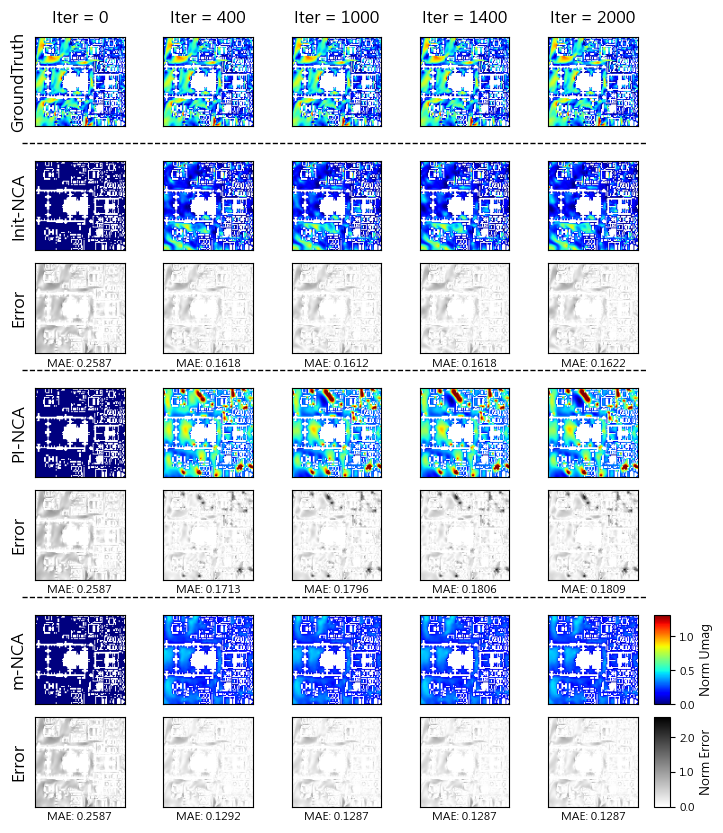

In [22]:
sample_idx = 1
patch_size = 100 // 2
# patch_size =128



B, T, S, C, H, W = val_rollout_states.shape
patch_rollout_states = val_rollout_states[
    ...,
    (H // 2 - patch_size) : (H // 2 + patch_size),
    (W // 2 - patch_size) : (W // 2 + patch_size),
]
patch_y_target = y_target[
    ...,
    (H // 2 - patch_size) : (H // 2 + patch_size),
    (W // 2 - patch_size) : (W // 2 + patch_size),
]


plt_states_over_time(
    patch_rollout_states[:, :, sample_idx, 6:11],
    patch_y_target[sample_idx, 6:11],
    patch_y_target[sample_idx, 2:3],
)

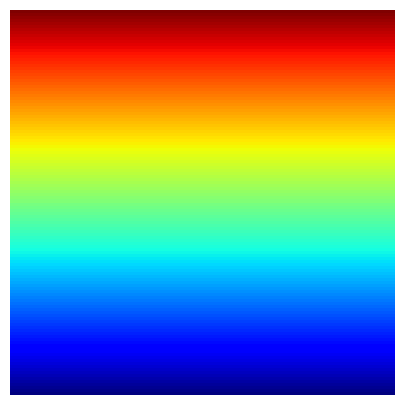

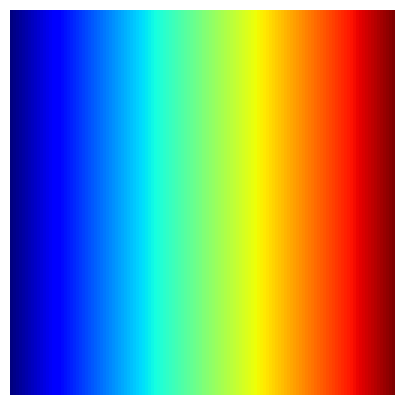

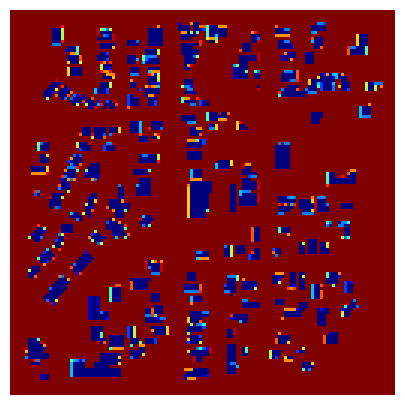

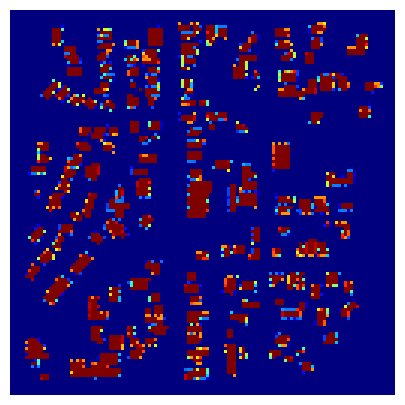

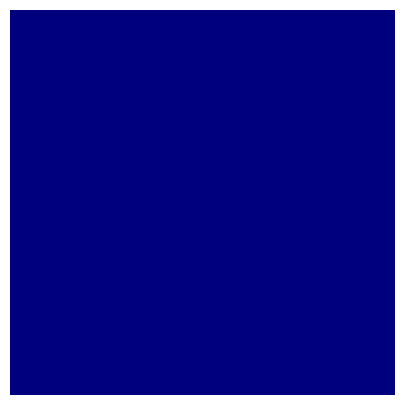

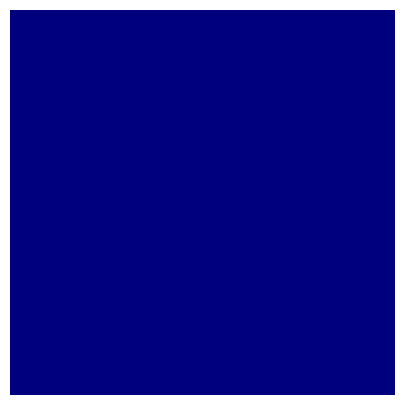

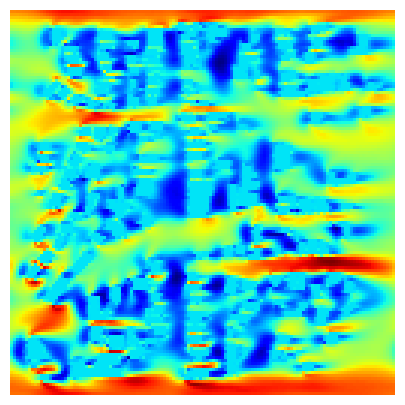

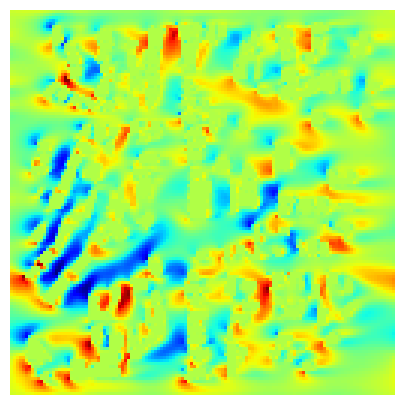

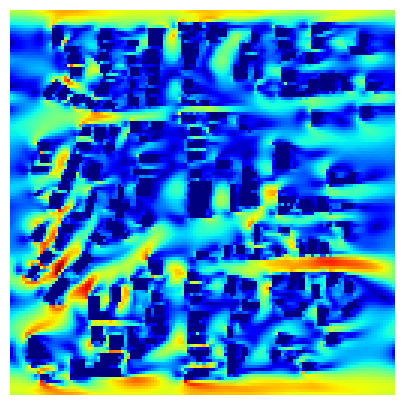

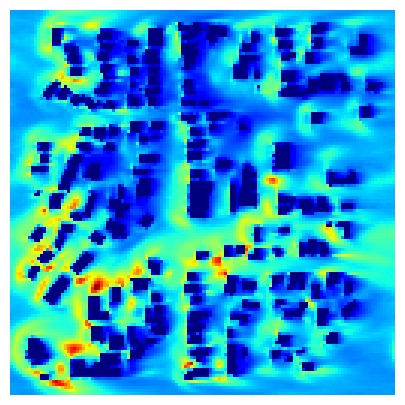

In [23]:
sample_idx=0
HWC = y_target[sample_idx, :10].cpu().permute( 1, 2, 0).numpy()

for c in range(HWC.shape[-1]):
    plt.figure(figsize=(6, 5))
    plt.imshow(HWC[...,c], cmap="jet", origin="lower")
    plt.axis("off")  # 關掉軸、標籤和刻度
    plt.show()